In [33]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')
    
#standard libraries
import json
import os
import time
from collections import defaultdict
from typing import List, Dict, Tuple, Union, Callable
from math import ceil

#external libraries
import pandas as pd
import numpy as np
from rich import print
from rich.pretty import pprint
from torch import cuda
from tqdm.notebook import tqdm
import tiktoken
from llama_index.text_splitter import SentenceSplitter
from sentence_transformers import SentenceTransformer

#external files
from src.preprocessor.preprocessing import FileIO
from src.database.database_utils import get_weaviate_client
from src.llm.prompt_templates import question_answering_prompt_series, generate_prompt_series, huberman_system_message
from src.llm.llm_interface import LLM

from dotenv import load_dotenv, find_dotenv
env = load_dotenv(find_dotenv(), override=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set Weaviate Client

In [2]:
#read env vars from local .env file
client = get_weaviate_client()

/anaconda/envs/vsa/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Import Data

In [3]:
data_path = '../../data/huberman_labs.json'
data = FileIO().load_json(data_path)
print(f'Total # of episodes: {len(data)}')

Total # of episodes: 193

### Set Tokenizer and Embedding Model

In [4]:
#tokenizer
encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0125')
#model
model = SentenceTransformer('all-MiniLM-L6-v2')

### Chunk Data

In [5]:
# corpi = []
# chunk_sizes = [64, 128, 256, 512]
# for cs in chunk_sizes:
#     splitter = SentenceSplitter(chunk_overlap=0, chunk_size=cs, tokenizer=encoding.encode)
#     corpus = create_dataset(data, model, splitter)
#     corpi.append(corpus)

# ---------------------  BREAK -------------------------

### Load Data from disk

In [65]:
data128 = FileIO().load_parquet('../../answer_key/data/huberman_minilm-128.parquet')
data256 = FileIO().load_parquet('../../answer_key/data/huberman_minilm-256.parquet')
data512 = FileIO().load_parquet('../../answer_key/data/huberman_minilm-512.parquet')

Shape of data: (51128, 13)
Memory Usage: 5.07+ MB
Shape of data: (23905, 13)
Memory Usage: 2.37+ MB
Shape of data: (11602, 13)
Memory Usage: 1.15+ MB


### Data Bundle Example

In [79]:
print(data256[0])

{
    'video_id': '-OBCwiPPfEU',
    'title': 'Dr. Matthew Walker: The Biology of Sleep & Your Unique Sleep Needs | Huberman Lab Guest Series',
    'length_seconds': 10773,
    'keywords': [
        'andrew huberman',
        'huberman lab podcast',
        'huberman podcast',
        'dr. andrew huberman',
        'neuroscience',
        'huberman lab',
        'andrew huberman podcast',
        'the huberman lab podcast',
        'science podcast'
    ],
    'view_count': 162689,
    'episode_num': 193,
    'episode_url': 'https://www.youtube.com/watch?v=-OBCwiPPfEU',
    'thumbnail_url': 'https://i.ytimg.com/vi/-OBCwiPPfEU/mqdefault.jpg',
    'guest': 'Dr. Matthew Walker',
    'summary': "In the Huberman Lab podcast episode featuring Dr. Matthew Walker, the discussion centers on the 
biology of sleep and how it impacts mental and physical health. They delve into the different stages of sleep, 
including non-REM and REM sleep, and their unique roles in brain function, such as memory consolidation and 
emotional regulation. They also explore practical strategies for improving sleep quality, such as managing light 
exposure, temperature, and timing of activities. Dr. Walker introduces the QQRT (Quality, Quantity, Regularity, and
Timing) formula for identifying individual sleep needs. The conversation highlights the detrimental effects of 
sleep deprivation on hormones, metabolism, and the risk of diseases like diabetes and Alzheimer's. They touch on 
the evolutionary importance of sleep, suggesting that its universal presence among species indicates a vital 
function for survival.",
    'doc_id': '-OBCwiPPfEU_0',
    'content': "Welcome to the Huberman Lab guest series, where I and an expert guest discuss science and 
science-based tools for everyday life. I'm Andrew Huberman, and I'm a professor of neurobiology and ophthalmology 
at Stanford School of Medicine. Today's episode marks the first in our six-episode series all about sleep. Our 
expert guest for this series is Dr. Matthew Walker, professor of neuroscience and psychology and the director of 
the Center for Sleep Science at the University of California, Berkeley. He is also the author of the bestselling 
book, Why We Sleep. During the course of the six-episode series, for which we release one episode per week, 
starting with this episode one, we cover essentially all aspects of sleep and provide numerous practical tools to 
improve your sleep. For instance, we discuss the biology of sleep, including the different sleep stages, as well as
why sleep is so important for our mental and physical health. We also talk about how sleep regulates things like 
emotionality and learning and neuroplasticity, that is your brain's ability to change in response to experience. 
And we discuss the various things that you can do to improve your sleep.",
    'content_embedding': [
        -0.022558197379112244,
        -0.021267101168632507,
        0.05489972233772278,
        0.07128095626831055,
        0.06499787420034409,
        0.05991670489311218,
        -0.01999964565038681,
        0.0005336686153896153,
        0.029837194830179214,
        -0.011097019538283348,
        -0.12040795385837555,
        0.007165419403463602,
        -0.03563549369573593,
        0.02375645749270916,
        -0.04856288060545921,
        -0.013060403987765312,
        -0.015637284144759178,
        -0.022509107366204262,
        0.018875673413276672,
        0.03482164070010185,
        0.029338041320443153,
        0.0023340671323239803,
        0.13704490661621094,
        -0.007225443609058857,
        -0.0004594717756845057,
        0.04137587547302246,
        0.03369123488664627,
        -0.06239315867424011,
        -0.00755976140499115,
        -0.06433174014091492,
        -0.016501767560839653,
        0.05270543694496155,
        0.012666614726185799,
        -0.049873534590005875,
        0.009051411412656307,
        0.010008124634623528,
        0.0075336480513215065,
        0.016

In [80]:
chunk_sizes = [128, 256, 512]
data_list = [data128, data256, data512]

### Show Chunk Size Examples

In [81]:
for size, d in zip(chunk_sizes, data_list):
    print(f'Chunk Size: {size}')
    print(f'Total # Chunks: {len(d)}')
    print(f'Sample Content: \n{d[0]["content"]}\n')
    print('-'*100)

Chunk Size: 128

Total # Chunks: 51128

Sample Content: 
Welcome to the Huberman Lab guest series, where I and an expert guest discuss science and science-based tools for 
everyday life. I'm Andrew Huberman, and I'm a professor of neurobiology and ophthalmology at Stanford School of 
Medicine. Today's episode marks the first in our six-episode series all about sleep. Our expert guest for this 
series is Dr. Matthew Walker, professor of neuroscience and psychology and the director of the Center for Sleep 
Science at the University of California, Berkeley. He is also the author of the bestselling book, Why We Sleep.

----------------------------------------------------------------------------------------------------

Chunk Size: 256

Total # Chunks: 23905

Sample Content: 
Welcome to the Huberman Lab guest series, where I and an expert guest discuss science and science-based tools for 
everyday life. I'm Andrew Huberman, and I'm a professor of neurobiology and ophthalmology at Stanford School of 
Medicine. Today's episode marks the first in our six-episode series all about sleep. Our expert guest for this 
series is Dr. Matthew Walker, professor of neuroscience and psychology and the director of the Center for Sleep 
Science at the University of California, Berkeley. He is also the author of the bestselling book, Why We Sleep. 
During the course of the six-episode series, for which we release one episode per week, starting with this episode 
one, we cover essentially all aspects of sleep and provide numerous practical tools to improve your sleep. For 
instance, we discuss the biology of sleep, including the different sleep stages, as well as why sleep is so 
important for our mental and physical health. We also talk about how sleep regulates things like emotionality and 
learning and neuroplasticity, that is your brain's ability to change in response to experience. And we discuss the 
various things that you can do to improve your sleep.

----------------------------------------------------------------------------------------------------

Chunk Size: 512

Total # Chunks: 11602

Sample Content: 
Welcome to the Huberman Lab guest series, where I and an expert guest discuss science and science-based tools for 
everyday life. I'm Andrew Huberman, and I'm a professor of neurobiology and ophthalmology at Stanford School of 
Medicine. Today's episode marks the first in our six-episode series all about sleep. Our expert guest for this 
series is Dr. Matthew Walker, professor of neuroscience and psychology and the director of the Center for Sleep 
Science at the University of California, Berkeley. He is also the author of the bestselling book, Why We Sleep. 
During the course of the six-episode series, for which we release one episode per week, starting with this episode 
one, we cover essentially all aspects of sleep and provide numerous practical tools to improve your sleep. For 
instance, we discuss the biology of sleep, including the different sleep stages, as well as why sleep is so 
important for our mental and physical health. We also talk about how sleep regulates things like emotionality and 
learning and neuroplasticity, that is your brain's ability to change in response to experience. And we discuss the 
various things that you can do to improve your sleep. Everything from how to time lighting, temperature, exercise, 
eating, and the various things that can impact sleep both positively and negatively, such as alcohol, cannabis, and
various supplements and drugs that have been shown to improve sleep. We also talk about naps, dreaming and the role
of dreams, and lucid dreaming, which is when you dream and you are aware that you are dreaming. In today's episode 
one, we specifically focus on why sleep is so important and what happens when we do not get enough sleep or enough 
quality sleep. We also talk about the various sleep stages, and we also talk about a very specific formula that 
everyone should know for themselves called QQRT, which is an acronym that stands for quality, quantity, regularity,
and timing of sleep. Four factors which today you'll learn how to identify specifically for you what your optimal 
QQRT is, and then to apply that in order to get the best possible night's sleep, which of course equates to the 
best possible level of focus and alertness throughout your days. Both Dr.

----------------------------------------------------------------------------------------------------

### Set Queries

In [82]:
queries = ["How can the average person apply the principles of peak performance to achieve their goals more effectively?",
           "With so much conflicting information about diet and nutrition, what are some evidence-based nutritional strategies you've discussed that could help optimize for a longer, healthier lifespan?",
           "How do I become as tough as David Goggins",
           "What is the next step in the evolution of AI"]

### Change the query by indexing

#### Notice how changing the chunk size changes the retrieved results, which in turn affects the downstream responses from the LLM

In [83]:
client.show_all_collections()

['Huberman_subset_minilm_test',
 'Huberman_minilm_128',
 'Huberman_minilm_256',
 'Huberman_minilm_512']

In [90]:
collections = ['Huberman_minilm_128',
               'Huberman_minilm_256',
               'Huberman_minilm_512'
              ]
responses = []
rank = 0

#change index to change query
query = queries[1]
for cls, size in zip(collections, chunk_sizes):
    response = client.vector_search(query, cls, limit=3, return_properties=['content', 'video_id', 'summary', 'guest', 'doc_id'])
    responses.append(response)
    print(f'Query: {query}\n\n')
    print(f'Response with chunk size: {size}')
    print(f'Video ID: {response[rank]["video_id"]}')
    print(f'Doc ID: {response[rank]["doc_id"]}')
    print(f'Guest: {response[rank]["guest"]}')
    print(f'Score: {response[rank]["distance"]}')
    print(f'Content: {response[rank]["content"]}')
    print(f'Summary: {response[rank]["summary"]}')
    print('-'*100)

Query: With so much conflicting information about diet and nutrition, what are some evidence-based nutritional 
strategies you've discussed that could help optimize for a longer, healthier lifespan?

Response with chunk size: 128

Video ID: K4Ze-Sp6aUE

Doc ID: K4Ze-Sp6aUE_209

Guest: Dr. Layne Norton

Score: 0.39061349630355835

Content: And the second thing is if you look at any macronutrient isolation, I can make a mechanistic argument that
it's going to kill you. So fat, if you take in fat, it decreases flow-mediated dilation. Flow-mediated dilation is 
important for heart health in the short term. Carbohydrates stimulate insulin. Insulin, you know, pro-inflammatory 
and all these other things. And so I can make an argument for any single macronutrient to be negative for 
longevity. I really want people, this is something that even scientists get wrong.

Summary: In the Huberman Lab Podcast episode with Dr. Layne Norton, they discuss a wide range of topics related to 
nutrition, fitness, and body composition. Dr. Norton, an expert in protein metabolism, fat loss, and nutrition, 
dives into the concept of energy balance and how we extract energy from food. They cover the controversial topic of
artificial sweeteners and their safety and efficacy for weight loss, the impact of the gut microbiome on food 
metabolism, the effectiveness of fasting and intermittent fasting, and the importance of protein intake tailored to
individual needs and activities. They also explore various diets (ketogenic, vegan, vegetarian, carnivore, 
omnivore) and the necessity of essential amino acids for health and body composition. Additionally, they touch upon
the science-backed supplements that support fitness goals. Dr. Norton emphasizes the importance of understanding 
both the scientific mechanisms and real-world applications of nutritional science, highlighting the significance of
choosing a sustainable diet for long-term health and weight management.

----------------------------------------------------------------------------------------------------

Query: With so much conflicting information about diet and nutrition, what are some evidence-based nutritional 
strategies you've discussed that could help optimize for a longer, healthier lifespan?

Response with chunk size: 256

Video ID: 7R3-3HR6-u4

Doc ID: 7R3-3HR6-u4_33

Guest: Dr. Satchin Panda

Score: 0.38581931591033936

Content: But what I think people take away from that is, oh, time-restricted feeding isn't valuable, which is not 
the case. I think for many people, it's a convenient way to eat because, at least for people like me, it's simpler 
to designate between portions of my day when I'm eating and portions of my day when I'm not eating as opposed to 
portion control. For other people, portion control can work. But all of that is related to either maintenance or 
loss of weight. None of it deals with the potential health benefits independent of weight loss. And so I think that
if we can segment those out, obviously in humans, it's hard to know if a given Yeah. So what can we say about 
time-restricted feeding and longevity in terms of biomarkers or in terms of any other indication that people who 
start and stop their feeding window at a consistent time, somewhere between 8 and 12 hours per 24-hour cycle, are 
tilting the scales towards living longer as opposed to living shorter? This example of this news article that you 
mentioned is really interesting because that relates to Joe Takashi's study.

Summary: In the episode featuring Dr. Satchin Panda, the discussion centers on the impact of circadian rhythms and 
time-restricted eating, also known as intermittent fasting, on health and longevity. Dr. Panda's research has shown
that aligning eating patterns with our internal biological clocks can improve various aspects of health, including 
liver and brain function, mood, and cognitive performance. The conversation delves into the science behind fasting,
the importance of consistency in meal timing, and the effects of different fasting durations. Dr. Panda emphasizes 
that while intermittent fasting is often associated with calorie restriction, his studies focus on the timing of 
eating without reducing caloric intake. The podcast also touches on the broader implications of circadian 
behaviors, such as light exposure and social activities, on our biology and psychology.

----------------------------------------------------------------------------------------------------

Query: With so much conflicting information about diet and nutrition, what are some evidence-based nutritional 
strategies you've discussed that could help optimize for a longer, healthier lifespan?

Response with chunk size: 512

Video ID: 7R3-3HR6-u4

Doc ID: 7R3-3HR6-u4_16

Guest: Dr. Satchin Panda

Score: 0.36932361125946045

Content: I think for many people, it's a convenient way to eat because, at least for people like me, it's simpler 
to designate between portions of my day when I'm eating and portions of my day when I'm not eating as opposed to 
portion control. For other people, portion control can work. But all of that is related to either maintenance or 
loss of weight. None of it deals with the potential health benefits independent of weight loss. And so I think that
if we can segment those out, obviously in humans, it's hard to know if a given Yeah. So what can we say about 
time-restricted feeding and longevity in terms of biomarkers or in terms of any other indication that people who 
start and stop their feeding window at a consistent time, somewhere between 8 and 12 hours per 24-hour cycle, are 
tilting the scales towards living longer as opposed to living shorter? This example of this news article that you 
mentioned is really interesting because that relates to Joe Takashi's study. Because I described that if you split 
calories and eat throughout the day, throughout day and night, then the mice lived 10% extra. But if you now give 
mouse the same calorie restricted diet and feed them during daytime, whether within 12 hours or two hours, then the
mice live 10% extra. Beyond that? Yes. So 20% longer. 20%. Okay. So let me make sure I understand so that I make 
sure I understand. If you take a certain number of calories and you distribute them throughout the 24-hour cycle, 
it's caloric restriction, the mice will live 10% longer. If you, however, restrict that to the active cycle, so for
humans, the daytime, then they live 20% longer. So it's not just total caloric intake, meaning it's not just 
important to be sub-maintenance in calories for sake of longevity. It also is important as to when in the 24-hour 
cycle you eat those calories. Do I have that right? So now, still the story is not over because these mice were fed
during daytime and they're not supposed to eat. That's right. So for us, it would be the equivalent of being on the
night shift and only eating at night, but a sub-maintenance calorie diet, I guess is the right way to say it.

Summary: In the episode featuring Dr. Satchin Panda, the discussion centers on the impact of circadian rhythms and 
time-restricted eating, also known as intermittent fasting, on health and longevity. Dr. Panda's research has shown
that aligning eating patterns with our internal biological clocks can improve various aspects of health, including 
liver and brain function, mood, and cognitive performance. The conversation delves into the science behind fasting,
the importance of consistency in meal timing, and the effects of different fasting durations. Dr. Panda emphasizes 
that while intermittent fasting is often associated with calorie restriction, his studies focus on the timing of 
eating without reducing caloric intake. The podcast also touches on the broader implications of circadian 
behaviors, such as light exposure and social activities, on our biology and psychology.

----------------------------------------------------------------------------------------------------

### LLM Prompt Example

In [14]:
print(question_answering_prompt_series)

Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).
After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

```
Show Summary: <summary>
Show Guest: <guest>
Transcript: <transcript>
```

Start Series:
```
{series}
```
Question:

{question}

------------------------
1. If the context does not provide enough information to answer the question, then
state that you cannot answer the question with the provided context.
2. Do not use any external knowledge or resources to answer the question.
3. Answer the question directly and {verbosity}.
------------------------
Answer:

### LLM Call: using responses for each chunk size

In [86]:
llm = LLM()

In [87]:
llm.valid_models

{'openai': ['gpt-4-turbo-preview',
  'gpt-4-0125-preview',
  'gpt-4-1106-preview',
  'gpt-3.5-turbo',
  'gpt-3.5-turbo-1106',
  'gpt-3.5-turbo-0125'],
 'anthropic': ['claude-3-haiku-20240307',
  'claude-3-sonnet-2024022',
  'claude-3-opus-20240229'],
 'cohere': ['command-r', 'command-r-plus']}

In [89]:
for i, r in enumerate(responses):
    prompt = generate_prompt_series(query, r, 2)
    llm_response = llm.chat_completion(system_message=huberman_system_message,
                                       user_message=prompt, 
                                       temperature=0.1)
    print(f'LLM response from chunk size: {chunk_sizes[i]}')
    print(llm_response)
    print('-'*100)
    print()

LLM response from chunk size: 128

Some evidence-based nutritional strategies discussed in the Huberman Lab podcast that could help optimize for a 
longer, healthier lifespan include:

1. **Time-Restricted Eating**: Dr. Satchin Panda's research suggests that aligning eating patterns with our 
circadian rhythms through time-restricted eating can improve various aspects of health, including liver and brain 
function, mood, and cognitive performance. Consistency in meal timing, such as having a consistent feeding window 
of 8 to 12 hours per 24-hour cycle, may contribute to living longer.

2. **Intermittent Fasting**: Dr. Andrew Huberman discusses the effects of fasting and intermittent fasting on 
health. Intermittent fasting or time-restricted feeding can influence weight loss, muscle maintenance, organ 
health, and overall well-being. Different schedules of eating can impact health in numerous ways, including fat 
loss, muscle dynamics, and cognitive states.

3. **Understanding Macronutrients**: Dr. Layne Norton highlights the importance of understanding the effects of 
different macronutrients on health. While any single macronutrient can be argued to have negative effects on 
longevity when isolated, having a balanced intake of macronutrients tailored to individual needs and activities is 
crucial for overall health and body composition.

4. **Choosing a Sustainable Diet**: Dr. Layne Norton emphasizes the significance of choosing a sustainable diet for
long-term health and weight management. This involves understanding both the scientific mechanisms and real-world 
applications of nutritional science to ensure that the chosen diet supports health and longevity.

By incorporating these evidence-based strategies such as time-restricted eating, intermittent fasting, balanced 
macronutrient intake, and sustainable dietary choices, individuals may optimize their nutritional habits to promote
a longer and healthier lifespan based on the discussions in the Huberman Lab podcast.

----------------------------------------------------------------------------------------------------

LLM response from chunk size: 256

Based on the series of transcripts provided from the Huberman Lab podcast, some evidence-based nutritional 
strategies discussed to optimize for a longer, healthier lifespan include the concept of time-restricted eating or 
intermittent fasting. Dr. Satchin Panda and Dr. Andrew Huberman emphasize the importance of aligning eating 
patterns with our internal biological clocks by eating during specific periods of a 24-hour cycle. This approach 
has been shown to improve various aspects of health, including liver and brain function, mood, cognitive 
performance, weight loss, fat loss, muscle dynamics, organ health, genome, epigenome, inflammation, exercise, 
cognition, mood, and lifespan.

Both guests highlight that time-restricted feeding can positively impact weight loss, fat loss, and various health 
parameters. Dr. Panda's research indicates that consistent meal timing within a specific window of 8 to 12 hours 
per day may contribute to living longer and healthier. Dr. Huberman further explains that the perfect diet for an 
individual on a given day is contextual and depends on past and future activities, suggesting that tailoring one's 
diet and eating schedule can optimize health outcomes.

Therefore, the evidence-based nutritional strategy of time-restricted eating, focusing on when to eat rather than 
solely on what to eat, emerges as a key approach discussed in the podcast to potentially enhance longevity and 
overall well-being.

----------------------------------------------------------------------------------------------------

LLM response from chunk size: 512

Based on the series of transcripts provided from the Huberman Lab podcast, some evidence-based nutritional 
strategies discussed that could help optimize for a longer, healthier lifespan include:

1. Time-Restricted Feeding: Both Dr. Satchin Panda and Dr. Andrew Huberman emphasize the importance of aligning 
eating patterns with our internal biological clocks through time-restricted feeding. Studies have shown that 
consistently starting and stopping the feeding window at a specific time each day, typically between 8 and 12 hours
per 24-hour cycle, can lead to longevity benefits. For example, research mentioned by Dr. Panda indicates that mice
lived 20% longer when fed the same calorie-restricted diet during their active cycle (daytime for humans) compared 
to when calories were distributed throughout the entire day and night.

2. Contextual Eating: Dr. Huberman highlights the idea that there is no one-size-fits-all perfect diet for everyone
every day. Instead, the perfect diet for an individual is contextual and depends on factors like what was eaten the
day before and what activities are planned for the following day. Understanding the context in which a specific 
diet regimen is taking place, such as hormonal changes during puberty or the impact of time-restricted feeding, can
have a powerful and positive effect on various health parameters, including weight loss, fat loss, and overall 
health.

3. Pulsing Nutritional Interventions: Dr. David Sinclair discusses the concept of pulsing interventions like 
fasting and nourishing the body intermittently to promote vitality and potentially slow down the aging process. By 
exposing cells to periods of adversity through fasting or slight overnourishment followed by periods of 
nourishment, cells can activate defense mechanisms that may help combat the effects of aging. This pulsing approach
aims to mimic conditions that promote cellular resilience and longevity, contrasting with constant exposure to 
specific interventions.

These evidence-based nutritional strategies focus on the timing of food intake, the contextual nature of dietary 
choices, and the importance of pulsing interventions to optimize health and potentially extend lifespan based on 
the discussions in the Huberman Lab podcast episodes featuring Dr. Satchin Panda, Dr. Andrew Huberman, and Dr. 
David Sinclair.

----------------------------------------------------------------------------------------------------

# ---------------------  BREAK -------------------------

#### Model Encoding

![sbert_docstring]( 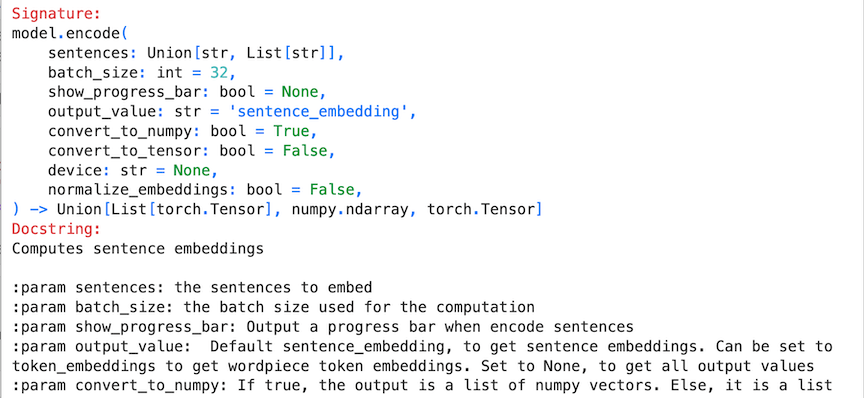)

We are going to work solely with the `model.encode` method for our text embedding creation.  There is a surprising amount of work being done under the hood with this function to include word tokenization, batching, GPU device setting, etc. If you really must know, feel free to review [lines 111 - 202 in the sentence-transformers Github repo](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/SentenceTransformer.py).  Here's a few notes for our course:
- `sentences`: accepts either a single string or a list of strings.  Very convenient.  This will allow us to enter all of the chunks from a single podcast episode at once, allowing for efficient processing and episode integrity.
- `batch_size`: under the hood the list of sentences in the input is batched.  Default is 32, so if your input was 128 sentences, then the model would translate that into 4 batches for processing.  DataLoader not needed.  Assuming you are using Google Colab for this notebook, use the default setting.
- `convert_to_numpy`: default output is a numpy array. However, because Weaviate does not accept the np.array data type, we'll want to eventually convert these arrays into Python lists.
- `device`: set to either cpu or GPU (`"cuda:0"`) for single GPU.  If `None` the function will handle this step for you and choose the fastest option! 

Let's take a quick tour of how this function works in practice.

In [63]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [38]:
#create sample sentences
text1 = "I ran down the road"
text2 = "I ran down the street"
text3 = "I ran down the lane"
text4 = "I ran down the avenue"
text5 = "I ran over to the house"

In [39]:
road_sentences = [text1, text2, text3, text4, text5]
road_vectors = model.encode(road_sentences)

In [40]:
road_vectors, road_vectors.shape

(array([[ 0.01464685,  0.0561101 ,  0.02563804, ..., -0.0925348 ,
         -0.04195407, -0.04409865],
        [ 0.04675803,  0.07742155,  0.04562965, ..., -0.0812416 ,
         -0.10972543, -0.02546268],
        [ 0.06553327,  0.0994243 , -0.04012905, ...,  0.00221833,
         -0.0342925 , -0.04802397],
        [ 0.05736331,  0.08300827,  0.00926694, ..., -0.10420122,
         -0.10806054, -0.03672466],
        [ 0.06660569,  0.03724336,  0.02164606, ..., -0.01440302,
         -0.1198651 ,  0.00423094]], dtype=float32),
 (5, 384))

As mentioned earlier the output vector dimension is 384 for this model, so we should expect to see 5 vectors of length 384 dims.  
Given that all of these vectors are of the same length we can compare them in vector space using a cosine simlarity function.  
The sentence-transformer's `semantic_search` function allows us to compare a single text (or multiple) to multiple texts and ranks them based on distance in vector space.  

# Cosine Similarity
---

![cosine]( 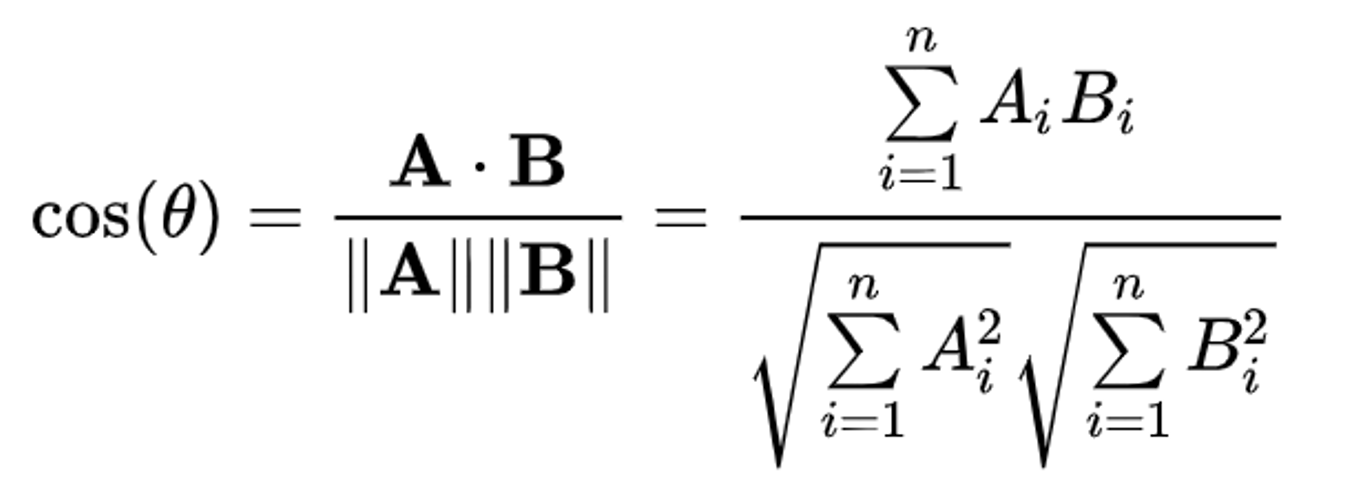)

In [44]:
from sentence_transformers.util import semantic_search

# we need to reencode our texts here with pytorch tensors to work with the semantic_search function
tensors = model.encode(road_sentences, convert_to_tensor=True)

# we'll set our query to the first sentence
query = model.encode(text1, convert_to_tensor=True)

#compare our query with all of the other sentences, including itself (expect to see a cos sim value of 1)
results = semantic_search(query_embeddings=query, corpus_embeddings=tensors)[0]

for result in results:
    print(f'Score: {round(result["score"],3)} - {road_sentences[result["corpus_id"]]}')

Score: 1.0 - I ran down the road

Score: 0.905 - I ran down the street

Score: 0.823 - I ran down the lane

Score: 0.805 - I ran down the avenue

Score: 0.673 - I ran over to the house

Here we can see that the word `road` is most semantically similar to itself, followed by the word `street`, followed by `lane`, and finally followed by `avenue`.  The final entry "`I ran over to the house`" is much further away in vector space, relatively, than the other sentences. As discussed in the course notes, embeddings measures the similarity between strings.  The next example shows how this concept of "similarity" is not always as intuitive as one might think.

In [42]:
#define some semantically similar sentences 
passages = ['Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams',
            'Tom Bilyeu founded Quest Nutrition in 2010',
            'Tom Bilyeu, not known outside of those who listen to the Impact THeory',
            'Tom Bilyeu claims to have deadlifted 335 pounds on his show',
            'Tomcats are not neutered cats']

#we'll define a query that should be able to be answered by the passages
query = "Who is Tom Bilyeu"

tom_tensors = model.encode(passages, convert_to_tensor=True)
tom_query = model.encode(query, convert_to_tensor=True)
tom_results = semantic_search(query_embeddings=tom_query, corpus_embeddings=tom_tensors)
for result in tom_results[0]:
    print(f'Score: {round(result["score"],3)} - {passages[result["corpus_id"]]}')

Score: 0.709 - Tom Bilyeu, not known outside of those who listen to the Impact THeory

Score: 0.671 - Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams

Score: 0.67 - Tom Bilyeu founded Quest Nutrition in 2010

Score: 0.639 - Tom Bilyeu claims to have deadlifted 335 pounds on his show

Score: 0.248 - Tomcats are not neutered cats

### Caching

In [97]:
primary_keys = ['doc_id', 'video_id', 'content', 'content_embedding']
contents = [{k:v for k,v in d.items() if k in primary_keys} for d in data256]

In [108]:
cache = {}
for d in data256:
    if d['video_id'] in cache:
        continue
    else:
        cache[d['video_id']] = {k:v for k,v in d.items() if k not in primary_keys}

In [116]:
cache_list = [{k:v} for k,v in cache.items()]

In [118]:
contents[0]

{'video_id': '-OBCwiPPfEU',
 'doc_id': '-OBCwiPPfEU_0',
 'content': "Welcome to the Huberman Lab guest series, where I and an expert guest discuss science and science-based tools for everyday life. I'm Andrew Huberman, and I'm a professor of neurobiology and ophthalmology at Stanford School of Medicine. Today's episode marks the first in our six-episode series all about sleep. Our expert guest for this series is Dr. Matthew Walker, professor of neuroscience and psychology and the director of the Center for Sleep Science at the University of California, Berkeley. He is also the author of the bestselling book, Why We Sleep. During the course of the six-episode series, for which we release one episode per week, starting with this episode one, we cover essentially all aspects of sleep and provide numerous practical tools to improve your sleep. For instance, we discuss the biology of sleep, including the different sleep stages, as well as why sleep is so important for our mental and physica

In [119]:
cache_list[0]

{'-OBCwiPPfEU': {'title': 'Dr. Matthew Walker: The Biology of Sleep & Your Unique Sleep Needs | Huberman Lab Guest Series',
  'length_seconds': 10773,
  'keywords': ['andrew huberman',
   'huberman lab podcast',
   'huberman podcast',
   'dr. andrew huberman',
   'neuroscience',
   'huberman lab',
   'andrew huberman podcast',
   'the huberman lab podcast',
   'science podcast'],
  'view_count': 162689,
  'episode_num': 193,
  'episode_url': 'https://www.youtube.com/watch?v=-OBCwiPPfEU',
  'thumbnail_url': 'https://i.ytimg.com/vi/-OBCwiPPfEU/mqdefault.jpg',
  'guest': 'Dr. Matthew Walker',
  'summary': "In the Huberman Lab podcast episode featuring Dr. Matthew Walker, the discussion centers on the biology of sleep and how it impacts mental and physical health. They delve into the different stages of sleep, including non-REM and REM sleep, and their unique roles in brain function, such as memory consolidation and emotional regulation. They also explore practical strategies for improving